# Impact of multivalency in the formation of cellular membrane-less organelles

In this project, we simulate the interactions between monomers and polymers. The final goal is to simulate a probable behavior of a polymer system. A monomer, in our project, is a small, charged unit coupled up by covalent bonds, that may connect to other similar monomers. A collection of monomers is called a polymer. The system we simulate contains polymers of opposite charge. The polymers will try to move in a way that decreases the total energy of the system, resulting in a more stable state. For the first part of the project, we simulate a system that only contain monomers. In the second part, we expand our code to simulate a system of polymers as described above. Furthermore, the simulation is constructed by the Markov-Chain Monte Carlo algorithm in python. How the project was solved will be presented as we go.


## Code

### Installing modules 

In [2]:
# Imports used modules
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap, TwoSlopeNorm, BoundaryNorm
from matplotlib.cm import ScalarMappable
import time 

while True:
    try:
        # Imports Numba
        from numba import jit
        from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
        import warnings

        # Remove annoying deprecation warnings
        warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
        warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
    except:
        # If numba is not installed, installs numba and tries again
        %pip install numba
        continue
    break

### Defining constants 

In [3]:
kB = 1.38E-23    # Boltzmann constant

e = 1.60E-19    # Elementary
epsilon_0 = 8.85E-12    # Vacuum permitivity
epsilon_r = 78    # Relative permitivity
a_monomer = 23E-6    # Distance between monomers
a_polymer = 91E-6    # Distance between polymers


alpha_monomer = e**2 / (4*np.pi*epsilon_0*epsilon_r*a_monomer**2)    # Value of the energy constant alpha, used with monomers
alpha_polymer = e**2 / (4*np.pi*epsilon_0*epsilon_r*a_polymer**2)   # Value of the energy constant alpha, used with polymers

### Grid making functions 

<a id='generate_monomers'></a>

In [4]:
# Generates a grid with shape N x N, with M positive and M negative unique monomers
@jit(nopython=True)
def generate_grid_of_monomers(N, M):
    grid = np.zeros(N**2, dtype=np.int32)   # Creates an array 1D, that will be reshaped later to 2D
    indicis = np.arange(0, N**2, 1)   # Creates an array with all indicies in the grid
    np.random.shuffle(indicis)   # Shuffels the indicies, so that they come in a random order

    monomer_indicis = indicis[:M*2]  # Picks 2*M indicis which will become monomers. M positive and M negative.
    monomer_values = np.arange(1, M+1)    # Creates and array which will give unique values for each monomer.

    grid[monomer_indicis[:M]] = monomer_values   # Places the positive charge in grid
    
    grid[monomer_indicis[M:]] = -monomer_values # Places the negative charge in grid

    grid = np.reshape(grid, (N, N)) #Reshapes the list to NxN matrix
    return grid   # Returns the N x N grid with the monomers placed randomly

# Finds the 2D cardinal neighbors for index p, if the grid where to be reshaped from N**2 to N x N.
@jit(nopython=True)
def get_2D_neighbor_in_1D(p, N):
    p = int(p)    # Indicis must be integers
    x = p % N   # Finds the column index of p
    y = p // N # Finds the row index of p
    return (
        ((y-1)%N)*N + x, # North index
        N*y + (x-1)%N, # West index
        ((y+1)%N)*N + x, # South index
        N*y + (x+1)%N # East index
    )

# For the given 1D grid, places randomly a polymer with multivalency L and with the charge/polymer value of charge.
# NOTE: Edits the original copy off the given grid
@jit(nopython=True)
def generate_polymer(grid, N, L, charge):
    polymer_monomerPositions = np.zeros(int(L), dtype=np.int64)    # An array which will contain the indicies of all the monomers which will make up the polymer
    neighbors_all_monomers = np.empty(0)    # An array with indicies of the neighbors of the polymer being generated
    polymer_monomerPositions[0] = np.random.choice(np.arange(0,N**2)[np.where(grid == 0)], size=(1))[0]    # Places the first monomer randomly, in a position which is vacant
    for i in range(1, L):    # L - 1 iterations, one for each monomer not yet placed
        for a in get_2D_neighbor_in_1D(polymer_monomerPositions[i-1], N):    # Finds the neighbors of the newest polymer, and iterates through them
            if grid[a] == 0 and not (polymer_monomerPositions == a).any():    # Checks to see if the index is vacant
                neighbors_all_monomers = np.append(neighbors_all_monomers, a)    # If vacant, appends the index to the array
        if len(neighbors_all_monomers) == 0:    # If there are no vacant indcies left, the polymer generation fails
            return False
        
        neighbors_all_monomers = np.unique(neighbors_all_monomers)    # Removes redundant copies of indicies, such that every index listed is unique
        
        j = np.random.choice(np.arange(len(neighbors_all_monomers)), size=(1))[0]    # Picks a random index from all eligible monomer placments
        polymer_monomerPositions[i] = neighbors_all_monomers[j]    # Records the index picked
        neighbors_all_monomers = np.delete(neighbors_all_monomers, j)    # Removes the index from the array possible future placements of monomers

    for monomer_pos in polymer_monomerPositions:    # Iterates through all generated monomer indicies
        grid[int(monomer_pos)] = charge    # Places them in the grid, all with the same charge
    
    return True     # The polymer generation was successfull

# Generates a grid with shape N x N, with M positive and M negative unique polymers with multivalency L
@jit(nopython=True)
def generate_grid_of_polymers(N, M, L):
    N = int(N)
    generated = False     # A boolean which will becom True if the generation is successfull
    iterations = 0    # Records the amount of failed attempts to generate the grid
    while not generated:
        iterations += 1     # Records the attempt
        grid = np.zeros(N**2)    # Initilizez a 1D grid with length N^2, which will later be reshaped to N x N.
        generated = True
        for i in range(1, int(M+1)):     # Iterates the polymer generation process M times.
            # With each iteration both a negative and postive polymer is generated
            if generate_polymer(grid, N, L, i) and generate_polymer(grid, N, L, -i):     # If both are successfull it continues
                continue
            else:    # If one of them fails, the whole attempt is scrapped
                generated = False     # Changes the bool back to False, so that the while loop can continue
                break    # Exits the for loop
        if iterations == 20:      # If the generation process fails 20 times, the function itself will fail
            raise ValueError("Number of iterations exceeded limit")
    return np.reshape(grid, (N, N))    # Returns the grid reshaped to N x N

### Functions to handle grids and get information from grids

<a id='total_energy_grid'></a>

In [5]:
# Finds the indicies of the neighbors for the point given by (i, j) in the 2D grid with shape N x N
@jit(nopython=True)
def get_neighbors_coordinates(N, i, j):
    # [
    #     [X, N, X]
    #     [W, V, E]
    #     [X, S, X]
    # ]
    # V is the point with indicis i, j
    # Returns a list with the coordinates of the neighbors: [N, W, S, E]
    neighbor_coordinates = np.array([
        [i-1, j],    # North
        [i, j-1],    # West
        [i+1, j],    # South
        [i, j+1]     # East
    ])

    return neighbor_coordinates % N     # Returns the coordinates, with torus boundary conditions of the grid

# np.roll function equivalent which works with numba for 2D grids
# Rolls the grid along the axis given by the amount shift
# NOTE: Negative values shift in the oppisite direction
@jit(nopython=True)
def numba_roll(grid, shift, axis):
    out = np.zeros(grid.shape)     # Initilizes the output grid
    # Checks axis which is being rolled
    if axis == 0:     # If axis == 0, the rows are being rolled
        for i in range(grid.shape[0]):     # Iterates through every row
            out[i] = np.roll(grid[i], shift)      # Rolls the row with index i
    else:      # If the axis is 1, the columns are being rolled
        for i in range(grid.shape[1]):     # Iterates through every column
            out[:,i] = np.roll(grid[:,i], shift)      # Rolls the column with index i
    return out     # Returns the rolled grid, without changes to the original grid

# Finds the energy of a grid of monomers
# NOTE: If used with polymer grids, it will treat every monomer the same, without regards for the polymer which it originates
@jit(nopython=True)
def total_energy_grid(grid):
    charge_grid = np.sign(grid)      # Creates a copy of the grid, but with every charge being of size +-1
    # To find the energy of a monomer, the charge of the monomer is multiplied with the charge of all neighbor monomer charges:
    # V_monomer = charge_monomer(charge_north + charge_south + charge_west + charge_east)
    # V_monomer = charge_monomer(Sum of neighbor charges)
    # This operation needs to be done for every monomer.
    # The the sum of neighbor charges can be expressed as a matrix, where every sum is given the same index as its corresponding monomer charge.
    # Then by multipliying element-wise the matrix of charges and the sum charges, every monomer energy is found
    charge_sum = np.zeros(grid.shape) 
    for rolled_grid in (
        numba_roll(charge_grid, 1, 0),      # The North neighbor charges
        numba_roll(charge_grid, -1, 0),     # The South neighbor charges
        numba_roll(charge_grid, 1, 1),      # The West neighbor charges
        numba_roll(charge_grid, -1, 1)      # The East neighbor charges
    ): charge_sum += rolled_grid     # Sums the neighbor grids
    return np.sum(charge_grid * charge_sum)/2     # Returns the sum of all monomer energy values dividied by two, since every energy pair is counted twice.


#This function detects where the matrix has nonzero-elements, and returns its coordinates
@jit(nopython=True)
def get_polymers(grid):
    polymer_values = np.unique(grid) #Gathers all the polymer values in the grid
    for indicis in np.where(polymer_values == 0):
        polymer_values = np.delete(polymer_values, indicis) 
    
    return polymer_values


@jit(nopython=True)
def count_monomers(grid):
    return int(np.sum(np.sign(np.abs(get_polymers(grid)))))

#This function choses a random polymer from the grid, and returns its coordinates
@jit(nopython=True)
def get_polymer_indicis(grid, polymer_value):
    polymer_indicis = np.where(grid == polymer_value)
    
    indicis_array = np.zeros((len(polymer_indicis[0]), 2), dtype=np.int32)
    for i in range(len(polymer_indicis[0])):
        indicis_array[i, 0] = polymer_indicis[0][i]
        indicis_array[i, 1] = polymer_indicis[1][i]
    return np.transpose(indicis_array)

# Returns a random cardinal direction
@jit(nopython=True)
def random_direction():
    l = [
        (-1, 0),
        (0, -1),
        (1, 0),
        (0, 1)
    ]
    return l[np.random.choice(np.array([0, 1, 2, 3]), size=(1))[0]]

# In the grid given, updates the position of a polymer
@jit(nopython=True)
def move_polymer(grid, prev_pos, new_pos, polymer_value):
    for i in range(np.shape(prev_pos)[1]):
        x0 = prev_pos[1, i]
        y0 = prev_pos[0, i]
        grid[y0, x0] = 0
    for i in range(np.shape(prev_pos)[1]):
        y = new_pos[0, i]
        x = new_pos[1, i]
        grid[y, x] = polymer_value[0]

# This function checks if the new position of a polymer is legal, i.e. checks if the new positions are occupied by 0 or the polymer value
# Returns True or False with regards of the legality of the move
@jit(nopython=True)
def legal_move(grid, new_position, polymer_value):
    for i in range(len(new_position[0])):
        y = int(new_position[0, i])
        x = int(new_position[1, i])
        p = grid[y, x]
        if p == 0 or p == polymer_value: #only returns False if the new position is neither 0 nor the polymer value
            continue
        return False
    return True

# This function inputs the previous position of a polymer and finds the new indices of the new position
@jit(nopython=True)
def get_new_polymer_pos(polymer_indicis, direction, N):
    movement = np.zeros(np.shape(polymer_indicis), dtype=np.int32)
    movement[0, :] = direction[0]
    movement[1, :] = direction[1]
    return (polymer_indicis + movement) % N

# Finds the total energy of the system
# Is_polymer = False: Finds the monomer energy
# Is_polymer = True: Finds the polymer energy
@jit(nopython=True)
def total_energy_polymer(grid, is_polymer=True):
    if not is_polymer:
        return total_energy_grid(grid)    # Returns monomer energy

    charge_grid = np.sign(grid)    # Grid with only the charges, regardless of polymer
    other_grid = np.zeros(grid.shape)    # Grid to contain the sum of neighbor charges for every monomer, unless they are from the same polymer
    l = [    # List of cardinal directions
        (-1, 0),
        (1, 0),
        (-1, 1),
        (1, 1)
    ]
    for i in range(4):
        direction = l[i]     # Picks a cardinal direction
        rolled_grid = numba_roll(grid, direction[0], direction[1])     # Rolls the grid, so every monomer has the same position as their neighbor in the given cardinal direction
        other_grid += np.sign(np.where(rolled_grid != grid, rolled_grid, np.zeros_like(rolled_grid)))     # Checks if the monomer is from the same polymer as their neighbor, and sums the neighbor charges if they are not
    
    # Multiplies the sum of charges and the monomer charges element wise
    # Summates every energy contribution
    # Returns the sum divided by two, since every energy contribution is counted twice. (Neighbor-Monomer energy comes in pairs)
    return np.sum(charge_grid * other_grid)/2     

# The move function for monomers, and rigid polymer movement.
# direction: Cardinal direction of the movement
# polymer_value: The polymer in question which is being moved
# N: Dimension of the grid (N x N)
@jit(nopython=True)
def monomer_move(prev_grid, direction, polymer_value, N):
    polymer_indicis = get_polymer_indicis(prev_grid, polymer_value)    # Finds the indicies for all monomers in a polymer/monomer
 
    new_position = get_new_polymer_pos(polymer_indicis, direction, N)    # Finds the new indicies for the moved polymer

    if not legal_move(prev_grid, new_position, polymer_value):     # Checks if the move was legal
        return prev_grid, False     # Returns a copy of the grid unchanged if not legal, and False
    grid = prev_grid.copy()    # Creates a copy of the grid, so that the original is unchanged
    move_polymer(grid, polymer_indicis, new_position, polymer_value)    # Moves the polymer
    return grid, True     # Returns the grid, with the polymer moved, and True

### Visualization 

<a id='visualize_grid'></a>

In [6]:
# Input a list of grids and titles, and plots them accordingly
def visualize_grid(grids, title=None):

    if type(grids) is not list:
        if type(grids) is tuple:
            grids = list(grids)
        else:
            grids = [grids]
    if type(title) is not list and title is not None:
        if type(title) is tuple:
            title = list(title)
        else:
            title = [title]
    n = len(grids)

    fig, axes = plt.subplots(2, n, figsize=(7*n, 7.5), gridspec_kw={'height_ratios': [7, 0.5]})

    for i in range(n):
        if n == 1:
            ax = axes[0]
            cax = axes[1]
        else:
            ax = axes[0][i]
            cax = axes[1][i]

        bounds = list(np.sort(get_polymers(grids[i])))

        if np.min(bounds) < 0:
            cmap = plt.cm.seismic
            norm=TwoSlopeNorm(vcenter=0.)
            cbar_norm = BoundaryNorm(sorted([0] + bounds), cmap.N)
            
            ax.pcolormesh(grids[i][::-1], cmap=cmap, norm=norm)

            fig.colorbar(ScalarMappable(norm=cbar_norm, cmap=cmap),
                        cax=cax, orientation='horizontal',
                        label="")
        else:
            grids[i] = np.ma.masked_where(grids[i] == 0, grids[i])
            cmap = plt.cm.get_cmap("brg")
            cmap.set_bad(color="white")
            norm = BoundaryNorm(bounds + [bounds[-1] + 1], cmap.N)
            cbar_norm = norm
            
            ax.pcolormesh(grids[i][::-1], cmap=cmap, norm=norm)

            fig.colorbar(ScalarMappable(norm=cbar_norm, cmap=cmap),
                        cax=cax, orientation='horizontal',
                        label="", ticks=bounds)

        ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
        ax.grid(False)

        if len(bounds) > 60:
            cbarx[i].set_ticks([])


        if title is not None:
            ax.set_title(title[i])

    plt.show()

### Clustering

<a id='clustering'></a>

In [7]:
# A np.delete equivalent that works with numba. Deletes a row with index [row]
@jit(nopython=True)
def delete_workaround(arr, row):
    shape = np.shape(arr)
    newArr = np.zeros((shape[0]-1, shape[1]), dtype=np.int32)
    for i in range(row):
        newArr[i] = arr[i]
    for i in range(row, shape[0]-1):
        newArr[i] = arr[i + 1]
    
    return newArr

# Changes the the given point(i, j) in the grid to the new cluster value
# Checks if there are any neighbors which are not part of a cluster yet, and uses recursion to add the relevant neighbors to the cluster
@jit(nopython=True)
def cluster_recursion(grid, cluster_value, N, i, j):
    grid[i, j] = cluster_value
    neighbors = get_neighbors_coordinates(N, i, j)
    for ni, nj in neighbors:
        if grid[ni, nj] == -1:
            grid = cluster_recursion(grid, cluster_value, N, ni, nj)
    return grid     # Returns the grid with the finished cluster, when no neighbors are left

# Returns a copy of the grid, with every cluster of monomers/polymers now connected (With a unique cluster value for every cluster)
@jit(nopython=True)
def cluster_grid(prev_grid, N):
    grid = -np.sign(np.abs(prev_grid.copy()))     # Creates grid with only -1 in every monomer position
    done = False    # When done is True, exits the loop
    cluster_value = 1    # Starts the cluster values at 1, and increments for every new cluster
    while not done:
        done = True
        i, j = np.transpose(get_polymer_indicis(grid, -1))[0]     # Picks a monomer which is not part of a cluster yet
        grid = cluster_recursion(grid, cluster_value, N, i, j)    # Grows the cluster from the initial monomer
        if (grid == -1).any():    # Checks if there is any monomer not in a cluster yet
            done = False
            cluster_value += 1    # Increments the cluster value by 1
    return np.abs(grid)    # Returns the finished cluster grid. 
# NOTE: Weird bugs when visualizing the cluster grid, because of -0 values
# Therefore returns the absolute value of the grid to circumvent the issue

### Polymer movement

In [8]:
# Moves a row/column of a polymer with the medium flexible rulesset
# Shift is the amount being moved, with signs indicating the direction of movement
@jit(nopython=True)
def row_move(prev_row, shift, polymer_value, N):
    row = prev_row.copy()    # Creates a copy of the row/column, incase the move is not legal
    # for j in range(N):    # Iterates through the row/column
    #     if row[j] == polymer_value:    # Checks if the point is part of the polymer
    #         row[j] = 0    # Sets the index to zero, since the monomer is moved
    row = np.where(row != polymer_value, row, np.zeros_like(row))    # Sets removes the polymer from the row/column
    for j in range(N):    # Iterates through the row/column
        if prev_row[j] == polymer_value:    # If the postion used to be a part of the polymer
            if prev_row[(j + shift)%N] == 0.0 or prev_row[(j + shift)%N] == polymer_value:    # Checks if the new monomer position is unoccupied
                row[(j + shift)%N] = polymer_value
            else:
                return prev_row

    return row
# Checks if the polymer of the given value is broken
# It accomplishes this by clustering a grid with only the the monomers for the given value.
# If more then one cluster is generated, the polymer is considered broken, and returns a bool accordingly
@jit(nopython=True)
def check_if_broken_polymer(grid, polymer_value, N):
    if np.sum(np.unique(cluster_grid(np.where(grid == polymer_value, grid, np.zeros_like(grid)), N))) != 1:
        return True
    return False

#Medium Flexible Move
@jit(nopython=True)
def medium_flexible_move(prev_grid, direction, polymer_value, N):
    grid = prev_grid.copy() #Creates a copy of the matrix 
    
    if np.abs(direction[1]) == 1: #Check if the move is
        shift = direction[1]
        for i in range(len(grid[0])):
            grid[i] = row_move(grid[i], shift, polymer_value, N)

    elif np.abs(direction[0]) == 1:
        shift = direction[0]
        for i in range(len(grid[0])):
            grid[:,i] = row_move(grid[:,i], shift, polymer_value, N)

    if check_if_broken_polymer(grid, polymer_value, N):
        return prev_grid, False
    return grid, True

### Simulation

In [9]:
# Moves a given polymer with the movement ruleset of choice, in the direction given
@jit(nopython=True)
def move_functions(grid, direction, polymer_value, N, movement):
    if movement == "monomer":
        return monomer_move(grid, direction, polymer_value, N)
    elif movement == "medium_flex":
        return medium_flexible_move(grid, direction, polymer_value[0], N)
    elif movement == "rigid":
        return monomer_move(grid, direction, polymer_value, N)

# The Monte Carlo algorithm
# Inputs a grid and returns a copy of the grid after being simulated with the parameters:
# T: Temperature
# Steps: Number of stesp
# movement: The movement rulset in question
@jit(nopython=True)
def monte_carlo(grid, steps, T, movement="monomer"):
    # Different functions are used to measure the energy of the system with monomers and polymers
    # alpha is therefore defined accordingly, and changes the is_polymer bool accordingly
    if movement == "monomer":
        alpha = alpha_monomer
        is_polymer = False
    else:
        alpha = alpha_polymer
        is_polymer = True
    
    # Defines the beta constant for the given temperature
    beta = 1 / (kB * T)
    # Finds the dimension of the N x N grid
    N = np.shape(grid)[0]
    
    # Finds the initial energy of the system
    energy = total_energy_polymer(grid, is_polymer)

    # Initializes an array to contain the energy of every step
    epsilon = np.zeros(steps)

    # Finds the polymer values in the grid
    polymer_values = get_polymers(grid)
    for i in range(steps):
        # Records the previous energy
        epsilon[i] = energy

        # Picks a random polymer to move
        polymer_value = np.random.choice(polymer_values, size=(1))

        # Picks a random direction to mvoe
        direction = random_direction() #array 
        
        # Finds the grid if the movement where to go through, and a bool to check if the movement is legal
        new_grid, legal_bool = move_functions(grid, direction, polymer_value, N, movement)
        
        # If the movement is legal, calculates the new energy of the system
        if legal_bool:
            new_energy = total_energy_polymer(new_grid, is_polymer)

            # If the energy is lowered, the new grid is accepted and the energy is recorded at the start of the next loop
            if new_energy < energy:
                grid = new_grid
                energy = new_energy
            # If the new energy is higher, there is still a probability that the system will change state regardless
            # The probabilty is given by the number of states, the temperature and the delta energy
            elif random.uniform(0, 1) < np.exp(-beta*(new_energy - energy)*alpha):
                grid = new_grid
                energy = new_energy
                
    # Records the final energy, and returns the final grid and all the energy values
    epsilon[steps-1] = energy
    return grid, epsilon

# A function to simluate monomer movement
def run_simulation_monomers(N, M, steps, T, show_grid=False, save=False):
    grid = generate_grid_of_monomers(N, M)
    new_grid, epsilon = monte_carlo(grid, steps, T)
    if show_grid:
        visualize_grid([grid, new_grid], title=(f"Before\nN = {N}, M = {M}, T = {T}",f"After\nN = {N}, M = {M}, T = {T}"))
    if __name__ == '__main__':
        length = len(epsilon)
        x = [a for a in range(length)]
        fig, ax = plt.subplots()
        ax.plot(x, epsilon)
        ax.set_title(f"Energy for {N} x {N} grid with {M} positive and negative monomers")
        ax.set_ylabel("Joule/alpha")
        plt.show()
    if save:
        np.savez(f"gridT_{T}", new_grid=new_grid)

### Cluster simulation

<a id='cluster_sim'></a>

In [10]:
# Returns a number of steps befitting the given temperature, and temperature range
@jit(nopython=True)
def get_steps(T, T_l, t_max = 100000, s = 1/200, C = 10000):
    return int(
        t_max * np.exp(-s*(T - T_l)) + C
    )

# Runs the monte carlo alogrithm and calculates the mean cluster size, for every 1000 steps.
@jit(nopython=True)
def cluster_size_of_T(T, T_l, N=15, M=25, n = 100):
    t_max = 300000
    t_equil = get_steps(T, T_l, t_max)
    t_r = 1000
    # Stores every measured cluster amount, and is used to calculate the mean cluster size
    cluster_amount = np.zeros((n))

    # Generates a grid which will be simulated
    grid = generate_grid_of_monomers(N, M)
    grid, epsilon = monte_carlo(grid, t_equil, T) # Runs the Monte Carlo until equilibrium is approximately reached
    for i in range(n): # Runs the algorithm for t_r steps, n times
        grid, epsilon = monte_carlo(grid, t_r, T)
        # Turns the grid of monomers into a grid of clusters
        cluster = cluster_grid(grid, N) 
        # Counts the number of clusters, and records the value in the array
        cluster_amount[i] =  np.sum(np.sign(np.abs(get_polymers(cluster))))

    # Returns the cluster size at every timestep
    return 2*M / (cluster_amount) 


# Runs simulation of monomer grids, to find a mean cluster size with the parameters defined below
def cluster_sim():
    print("Start")
    T_l = 100    # Lower bound for the temperature range
    T_h = 1000   # Upper bound fot the temperature range
    n = 100      # Number of samples taken after equilibrium is reached
    number_of_temperatures = 10       # The amount of sim
    T_values = np.linspace(T_l, T_h, number_of_temperatures)
    cluster_size = np.zeros((number_of_temperatures, n))
    for i in range(len(T_values)):
        T = T_values[i]
        # Calculates and records the sampeled cluster sizes for the given temperature
        cluster_size[i] = cluster_size_of_T(T, T_l, n=n)
        # print(f"Done: {T}")
    # print("Finished")
    # Return the list of all sampeled values
    return cluster_size

# Runs the cluster simulation defined above, and plots the results
def run_cluster_sim():
    cluster_size = cluster_sim()

    T_l = 100
    T_h = 1000
    number_of_sims = 10
    T_values = np.linspace(T_l, T_h, number_of_sims)
    mean_d = np.zeros(number_of_sims)
    d_std = np.zeros(number_of_sims)


    for i in range(len(T_values)):
        mean_d[i] = np.mean(cluster_size[i])
        d_std[i] = np.std(cluster_size[i])

    fig, ax = plt.subplots()
    ax.errorbar(T_values, mean_d, d_std, linestyle='None', marker='^')
    ax.set_xlabel("Temperature / K")
    ax.set_ylabel("Cluster size")
    ax.set_title("Mean_d(T), with standard deviation")
    ax.set_xticks(T_values)
    ax.set_yticks(np.arange(1, 15))

    plt.show()

### Polymer simulation

<a id='poly_sim'></a>

In [11]:
def run_simulation_with_polymers(N, M, L, steps, T, show_grid=False, movement="rigid", save=False): #Simulations with random grids.
    grid = generate_grid_of_polymers(N, M, L)
    new_grid, epsilon = monte_carlo(grid, steps, T, movement=movement)
    if show_grid:
        visualize_grid([grid, new_grid], title=(f"Before\nN = {N}, M = {M}, T = {T}",f"After\nN = {N}, M = {M}, T = {T}"))
    if __name__ == '__main__':
        length = len(epsilon)
        x = [a for a in range(length)]
        fig, ax = plt.subplots()
        ax.plot(x, epsilon)
        ax.set_title("Energy")
        ax.set_ylabel("Joule/alpha")
        plt.show()
    if save:
        np.savez(f"gridT_{T}", new_grid=new_grid)

    return new_grid, epsilon

def run_simulation_with_polymers_fixed_grid(grid, steps, T, show_grid=False, movement="rigid", save=False): #Simulation with a spesific grid.
    new_grid, epsilon = monte_carlo(grid, steps, T, movement=movement)
    if show_grid:
        visualize_grid([grid, new_grid], title=(f"Before\nN = {N}, M = {M}, T = {T}",f"After\nN = {N}, M = {M}, T = {T}"))
    if __name__ == '__main__':
        length = len(epsilon)
        x = [a for a in range(length)]
        fig, ax = plt.subplots()
        ax.plot(x, epsilon)
        ax.set_title("Energy")
        ax.set_ylabel("Joule/alpha")
        plt.show()
    if save:
        np.savez(f"gridT_{T}", new_grid=new_grid)

    return new_grid, epsilon


### Polymer clustering

<a id='polymer_cluster'></a>

In [13]:
@jit(nopython=True)
def get_steps_polymer(L, L_l, t_max = 50000, s = 1/40, C = 50000):
    return int(t_max * np.exp(-s*(L - L_l)) + C)

@jit(nopython=True)
def cluster_amount_polymer(T, L, L_l, n, movement="medium_flex", N=30, M=5):
    t_equil = get_steps_polymer(L, L_l)
    t_r = 1000

    cluster_amount = np.zeros((n))

    grid = generate_grid_of_polymers(N, M, L)
    grid, epsilon = monte_carlo(grid, t_equil, T, movement=movement)

    for i in range(n):
        grid, epsilon = monte_carlo(grid, t_r, T, movement=movement)
        cluster = cluster_grid(grid, N)
        cluster_amount[i] = np.sum(np.sign(np.abs(get_polymers(cluster))))

    return cluster_amount

def poly_cluster(n, movement):
    T = 300
    number_of_sims = 13
    L_l = 3
    L_h = 39
    L_values = np.linspace(L_l, L_h, number_of_sims)
    cluster_amount = np.zeros((number_of_sims, n))
    print("Start")
    for i in range(number_of_sims):
        L = L_values[i]
        cluster_amount[i] = cluster_amount_polymer(T, L, L_l, n, movement)
        print(f"Done: {L}")
    print("Finished")
    return cluster_amount 

def run_sim_poly_cluster(movement="medium_flex"):
    number_of_sims = 13
    M = 5
    n = 50
    cluster_amount = poly_cluster(n, movement)
    L_values = np.linspace(3, 39, number_of_sims)
    mean_d_over_L = np.zeros(number_of_sims)
    d_std = np.zeros(number_of_sims)
    mean_m = np.zeros(number_of_sims)
    m_std = np.zeros(number_of_sims)
    

    for i in range(number_of_sims):
        mean_d_over_L[i] = np.mean(2*M * L_values[i] / cluster_amount[i]) / L_values[i]
        d_std[i] = np.std(2*M * L_values[i] / cluster_amount[i]) / L_values[i]
        mean_m[i] = np.mean(cluster_amount[i])
        m_std[i] = np.std(cluster_amount[i])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (14, 7))

    ax1.errorbar(L_values, mean_d_over_L, d_std, linestyle="None", marker="^")
    ax1.set_xlabel("L")
    ax1.set_ylabel("(Cluster size) / L")
    ax1.set_title("Mean_d(T)/L, with standard deviation")

    ax2.errorbar(L_values, mean_m, m_std, linestyle="None", marker="^")
    ax2.set_xlabel("L")
    ax2.set_ylabel("Cluster amount")
    ax2.set_title("Mean_m(T), with standard deviation")

    plt.show()


def poly_cluster_compare(n):
    T_values = np.linspace(100, 1000, 10)
    number_of_sims = 10
    L_l = 3
    L_h = 39
    L_values = np.linspace(L_l, L_h, number_of_sims)
    cluster_amount = np.zeros((10, 10, n))
    print("Start")
    for i in range(len(T_values)):
        T = T_values[i]
        for j in range(number_of_sims):
            L = L_values[j]
            cluster_amount[i, j] = cluster_amount_polymer(T, L, L_l, n)
        print(f"Done: {T}")
    print("Finished")
    return cluster_amount 


def run_sim_poly_cluster_compare():
    number_of_sims = 10
    M = 5
    n = 1
    cluster_amount = poly_cluster_compare(n)
    L_values = np.linspace(3, 39, 10)
    T_values = np.linspace(100, 1000, 10)
    X, Y = np.meshgrid(L_values, T_values)

    mean_d_on_L = np.zeros((10, 10))
    mean_m = np.zeros((10, 10))

    for i in range(number_of_sims):
        for j in range(number_of_sims):
            mean_d_on_L[i, j] = np.mean(2*M / cluster_amount[i, j])
            mean_m[i, j] = np.mean(cluster_amount[i, j])

    fig1, ax1 = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15, 15))
    fig2, ax2 = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15, 15))

    ax1.plot_surface(X, Y, mean_d_on_L)
    ax1.set_title("Mean d / L")
    ax1.set_xlabel("L")
    ax1.set_ylabel("T/K")
    ax1.view_init(30, 120)

    ax2.plot_surface(X, Y, mean_m)
    ax2.set_title("Mean m")
    ax2.set_xlabel("L")
    ax2.set_ylabel("T/K")
    ax2.view_init(30, -60)


    plt.show()

# Part 1: Monomers 

To get our bearings, we firstly want to able to simulate a system of monomers. In this model the monomers are not going to connect into polymers, but rather move freely around the grid. To model the real world behaviour we want a simulation in which the system tries to minimize its energy, with regards to the laws of thermodynamics. 

The first step will be to genereate a surface containing static monomers. To achieve this we model the surface as a discrete grid with size N x N. In the grid "0" means that there are no monomers in that position, and other values represents the existance of a monomer there. The different monomers/polymers will have different values associated with themselves, with the sign indicating the sign of the charge. Too simplify greatly we will assume that every monomer has the same amount of charge, namely q=e.

With these assumptions in mind we can generate a random N x N grid with M positive and M negative monomers placed randomly. We achieve this by creating a 1D array with length $N^2$, and randomly placing values from -M to M, with the rest being 0. This is achived by the function [generate_grid_of_monomers()](#generate_monomers)

To visualize the system, we use the function [visualize_grid()](#visualize_grid), which plots the grid as a colormesh. Different colors represent different monomers, with blue and red hues representing negative and positive charges accordingly. Below is an example of a grid of monomers being generated and visualized as decribed.



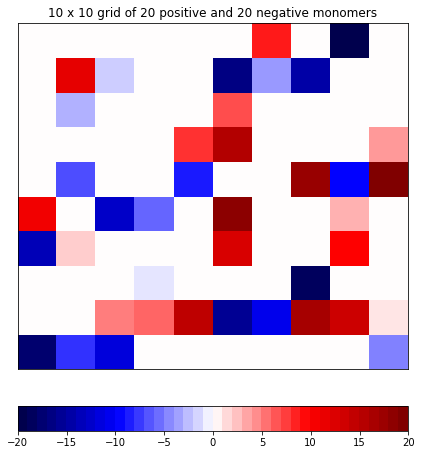

In [12]:
N_1 = 10  # Size of the grid
M_1 = 20 # Number of positive and negative monomers in the grid

monomer_grid = generate_grid_of_monomers(N_1, M_1)


visualize_grid(monomer_grid, title=f"{N_1} x {N_1} grid of {M_1} positive and {M_1} negative monomers")

Now that we can both generate a grid of monomers and visualize it, the next step will be to implement the Monte Carlo algorithm for this system. In general the Monte Carlo algorithm needs a way to calcualte the energy of the system and way to usher movement in the system. 

As mentioned in the introduction, the Monte Carlo algorithm tries to bring the system to a state which is a local energy minima, while allowing some sporadic movement which results in a higher total energy.
Our implementation accomplishes this by taking in the initial grid we generated, and sum up the energy of the entire system. The code then tries to move a monomer/polymer. If the random move turns out not to be a legal move, the move is rejected and a new iteration follows. On the other hand if the move is legal, the algorithm will calculate the total energy of this new configuration. If the new energy is lower than for the previous grid, the move is accepted, and that new grid will be the base for the next itteration. 


Even so, there is still a non zero probabillity that the system will spontanously accept the move even if the energy increases. This is calculated using the thermodynamical probabillity of states function below, with regards to the temperature of the system:

$$
e^{-\beta(E(S_n) - E(S_i))} \lessgtr p, p \in_{R} [0, 1]
$$


This process loops for a set number of itrerations, and then returns the final grid and the energy for every step. To return this, we mainly need a function that calculates the total energy of a system, and a function that makes a given monomer move.


To calculate the energy of each grid point, we use the function [total_energy_grid()](#total_energy_grid). The function makes use of the numba.roll, which is our own equivalent function to numpy.roll. Namely we want to roll the grid in all cardinal directions.
The reason for this is to make a single matrix, with the sum of the neighbor charges for an element in position (i, j) to also be in that position (i, j), in this new neighbor charge sum matrix. Note that the magnitude of the charges is either -1 or 1, and the (sign) of the monomer value is the only thing that matters.
Since any point in the grid has 4 cardinal neighbors this summation will be of the grid with charges, rolled in four different directions and then summed up. Since every monomer (i, j) corrosponds with a total neighbor charge with position (i, j), we can find the energy of all monomers by multiplying the matrix element-wise, with regards to the potenial energy defined by:

$$
V_{kl} = \begin{cases}
      1 & w_kw_l\alpha\text{ for cardinal neighbors}\\
      2 & 0 \text{ for non neighbors}\\
    \end{cases}
$$
With:

$$
\alpha = \frac{e^2}{4\pi\epsilon_0\epsilon_ra^2}
$$

Where a is the distance between monomers, a = 23µm and epsilon_r being the relative permativity, epsilon_r = 78.

Then to get the total energy of the grid we summate all of these contributions and divide by two. The reason we need to divide by two is because every energy contribution is counted twice, since neighbors comes in pairs. This function returns the energy with the dimensionless qunatity $E/\alpha$. This means in the Monte Carlo algorithm we multiply by alpha before the probabillistic increase in energy expression.

Below is the calculated energy for the grid we generated earlier. 

In [13]:
total_monomer_energy = total_energy_grid(monomer_grid)
print(f"The total energy of the monomer system above is: {total_monomer_energy}")

The total energy of the monomer system above is: 0.0


The next function we have to implement to run the Monte Carlo algorithm on a monomer system is a function that moves the monomers. This is modelled by the function [move_monomers()](#move_monomers). The function works by inputing the grid, the monomer in question and a direction to move the monomer. The direction is picked randomly by [random_direction()](#rand_dir). With some simple calculation the new position of the monomer is found. Subsequently the legality of the move is found, i.e. checks if the monomer moved to a vacant spot. If this check goes through a copy of the grid with the moved completed is returned.

At this point, we are ready to run a simulation of a monomer system. Below we make use of the function [run_simulation_monomer()](#run_simulation_monomer) to simulate the system with the Monte Carlo algorithm. 

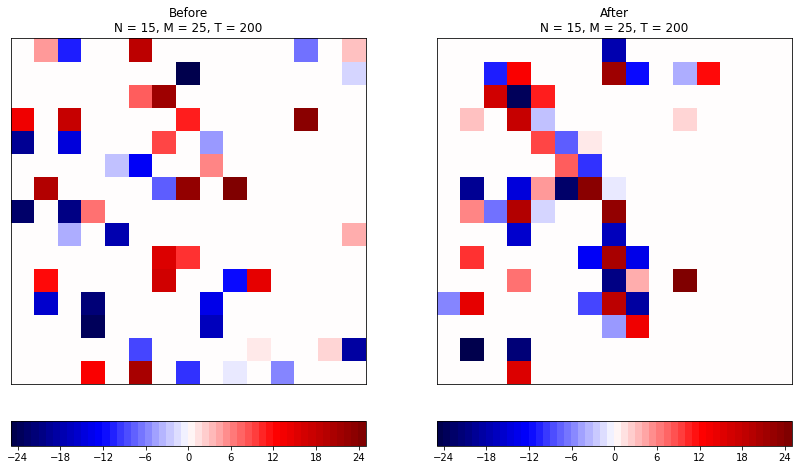

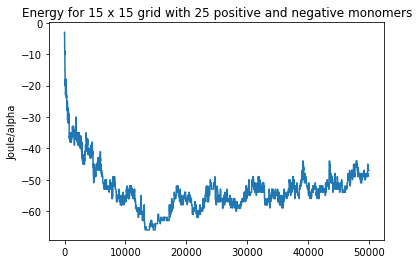

Run time for mono T=200: 21.336769342422485


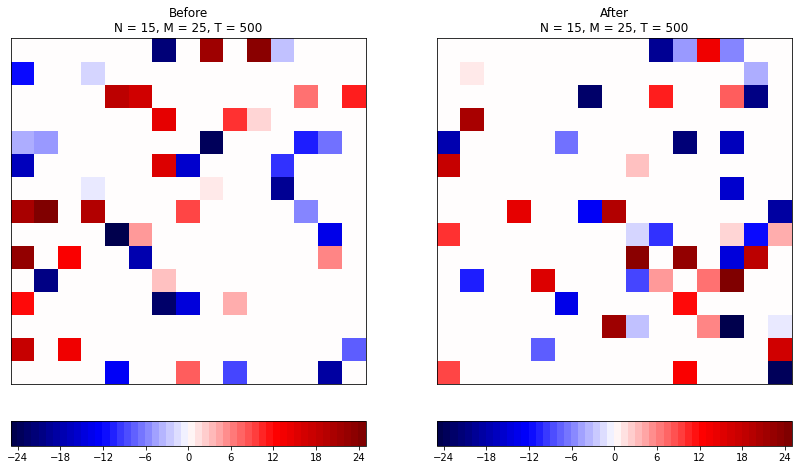

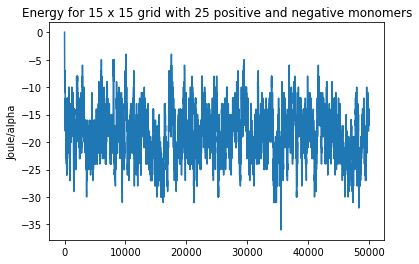

In [14]:
N_2 = 15
M_2 = 25

T1= 200
T2 = 500
t0_mono_200 = time.time()
run_simulation_monomers(N_2, M_2, 50000, T1, show_grid=True, save=True)
time_monomer = time.time() - t0_mono_200
print(f"Run time for mono T=200: {time.time() - t0_mono_200}")
run_simulation_monomers(N_2, M_2, 50000, T2, show_grid=True, save=False)

When we plot the energy for $T=200K$ and $T=500K$, it appears as if the system evolves differently. For $T=500K$ the energy fluctuates with a higher amplitude around the equlibrium energy than $T=200K$. The equilibrium energy looks to be higher with temperature. This may be because the monomors move sporadically at higher temperatures, since a spontanious increase in energy is more likely. The time it takes for the system to reach equilibrium seems to also be dependent on temperature. For the simulation with $T=200K$ the system reached equilibrium after aproximately 10000 Monte Carlo iterations. For higher temperatures we expect the system to have a higher entropy. This is reflected by how $T=500K$ looks to either start in equilibrium or reach it quite quickly. With higher entropy we expect more random behaviour, which is also how the system is initialized with the monomers being placed randomly. With a lower temperature the system will settle into a local energy minima, and be less able to find any lower energy states since it has fewer random events which could result in a lower energy state. However for the higher temperature case the system changes too erratically to settle firmly into a local energy minima. The local energy minima occur when the monomers arange in alternating positive and negative pattern, and gets its absolute lowest energy when all the monomers clump in one big cluster. At higher temperatues, the monomers will not clump up to large clusters as often as for lower tempertures. This is clear from the visualization of the grid at $T=200K$ and $T=500K$. 



By modifying the simulation above slightly, it is possible to examine the formation of aggregates. In other words the  clustering of monomers, as the system matures. In this model we define a cluster as a collection of monomers being connected as unbroken chains or clumps of cardinal neighbors. Unbroken in the sense that every monomer in a cluster can be mapped to another monomer in the cluster, by only taking steps with length 1 in a cardinal direction (i.e. diagonal moves are not allowed), without moving into the solvent or another cluster.

To find the clustering of a grid we set the value of all monomers to -1, indicating that the monomer or monomers in question is not yet apart of a cluster. Then we pick any position which is -1 and "grow" a cluster by finding its neighbors, changing them to a unique cluster value (1, 2, 3 ...) for that cluster, and using recursion repeats this process for the neighbors now incorporated into the cluster. This continues until there are no monomers adjacent to the cluster which is not already apart of the cluster. Then if there are any non-clustered monomers left the process is repeated as explained above. This process is achieved by the function [cluster_grid()](#clustering). Below is an example of the previousliy saved grid of the $T=200K$ Monte Carlo simulation from above being turned into a cluster grid. Since we are not interested in the charges when we cluster the monomers/polymers we only use positive values for the clusters, and give them colors without taking charge into considiration.

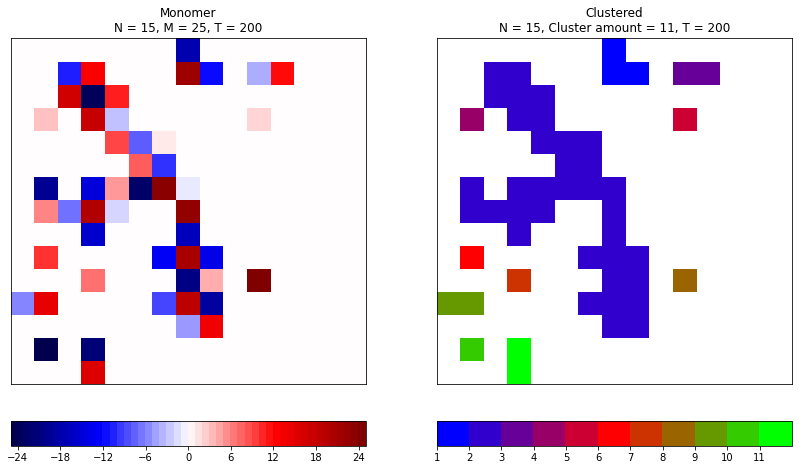

In [15]:
before_cluster = np.load("gridT_200.npz")["new_grid"]

after_cluster = cluster_grid(before_cluster, N_2)

cluster_amount = np.sum(np.sign(get_polymers(after_cluster)))

visualize_grid([before_cluster, after_cluster], title=(f"Monomer\nN = {N_2}, M = {M_2}, T = {T1}",f"Clustered\nN = {N_2}, Cluster amount = {cluster_amount}, T = {T1}"))


Now with a way to find the clustering of monomers, we can investigate the mean cluster size $\langle d \rangle$, for systems at equilibrium as a function of different temperatures. The range of temperatures we are investigating are 10 evenly spaced temperatures between 100K and 1000K. Number of steps until equilibrium for a given temperature is approximated with the parameters $T_l=100, s=1/200, C = 10000, t_{max}= 300000$ and the expression:  $t_{equil}(T) = t_{max}exp(-s(T-T_l)) + C$. For every temperature the initial grid will be different, with the parameteres $N=25$ and $M=25$. To calculate the mean we need to find the cluster size at different points in time after equilibrium. Since the system at t=t_equil is essentially the same at t=t_equil + 1, we sample every 1000 steps, instead of every step. This means we can assume that every sample is indepent, which permits use to approximate d by taking the mean: 

$$d \approx \langle d \rangle = (\frac{\sum_{t}\#Clusters(t)}{2Mn})^{-1}$$

To get an approximation for d, we chose to sample n=100 times after equilibrium. This simulation can be run using the function [run_cluster_sim()](#cluster_sim), as seen below:

Start


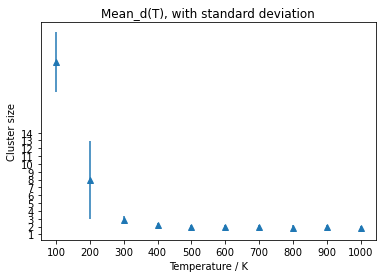

In [16]:
run_cluster_sim()

The simulation above shows that cluster size appears to be higher for lower temperatures. By earlier dicussions we concluded that bigger clusters, with monomers of oppsite charges next to each other will result in the lowest energy possible for the system. But at higher temperatures the likelihood that the energy spontanously increases is higher. Therefore at higher temperatures the system will look more random i.e. less structured, and the monomers will be more uniformly distribuated.

Even though we got a large deviation for the mean_d at lower temperatures, we will still argue that our choice of n is valid. The large standard deviation is the result of the size of clusters being more unstable for bigger clusters. That is because when the random increase in energy occurs, it can potenially break a large cluster into multiple parts or vice versa. For higher temperatures, the mean cluster size is about 2, so a spontanous separation of a cluster of size 2 into two cluster of size 1 is clearly less impactful, since the amount of clusters is large. Even with the occurrence of the energy increasing being rarer at lower values of T, a potenially large difference in the number of clusters can be observed when it occures.

Lets try to run the simulation multiple times, so that we can compare how initital conditions impact the evolution of the system.

Start


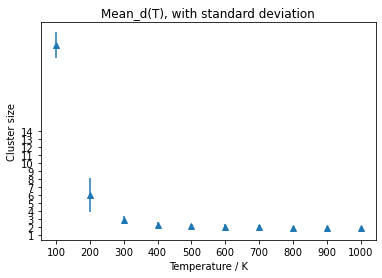

Start


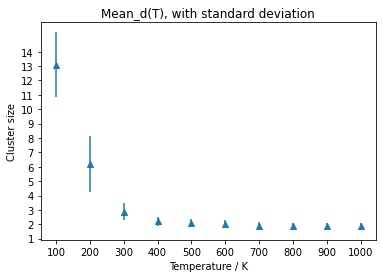

Start


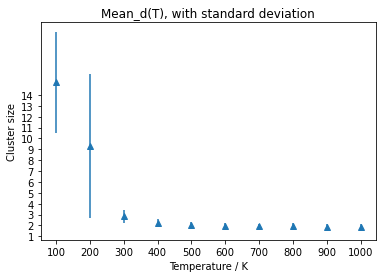

Start


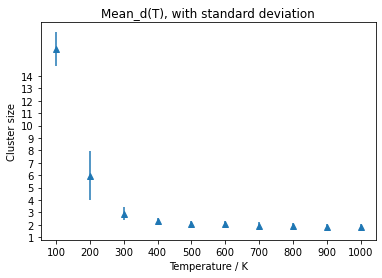

Start


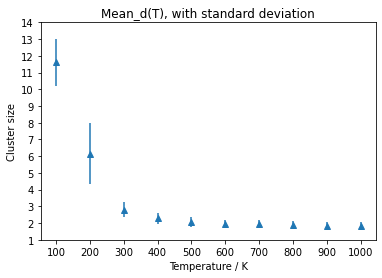

In [17]:
for i in range(5):
    run_cluster_sim()

The discrepancy of the mean cluster size between multiple simulations looks to be larger for lower temperatures. Since lower temperatures creates bigger clusters it looks to be dependant of the initial conditions. This is also what intuition tells us, since a random arrangment of monomers are not likely to be ordered in way with more structure, i.e. low entropy. And since the temperature is low, it is not likely to explore all potenial states of the grid which can result in a even lower energy state, i.e. bigger clusters.




# Part 2: Polymers

Up till this point the main focus has been on systems of monomers. In reality, monomers will try to make polymers. Therefore we want our Monte-Carlo simulation to also work with such a system. 

The first step is to make a grid of 2M polymers. To do this, we start with one randomly placed monomer in our grid, and then expand from this basis with one monomer at a time until we have a polymer of L monomers connceted with the same rules as unbroken clusters. We expand the polymer by finding all the neighbor coordinates of a all monomers currently in the polymer, and select a vacant neighbor position randomly from that list and incorporates this position into the polymer. When the polymer reaches the desired size L, a new polymer can be generated until all 2M polymers are generated. The same way as 2M monomers meant M positive and M negative monomers, 2M will also mean M positive polymers and M negative polymers. This generation is implemented by the function [generate_grid_of_polymers](#generate_monomers).

Below is an example of a polymer system with 4 polymers, each with multivalency L=25.  

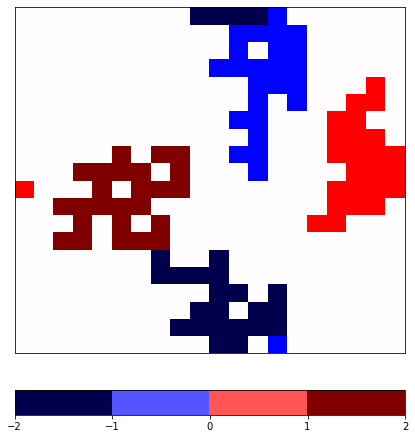

In [18]:
L = 25
N_2 = 20
M_2 = 2
grid_polymers = generate_grid_of_polymers(N_2,M_2,L)
visualize_grid(grid_polymers)

Following being able to generate a grid of polymers, we now want to implement and run the Monte Carlo algorithm with polymers. The Monte Carlo algorithm is fundamentally the same for both monomer and polymer systems. However, when simulating a polymer system, the calculation of the total energy is different from the monomer system. In addition, the polymers can move around the grid in different ways that we will get into later.

Firstly we need to calculate the total energy of the system. The energy formula is the same as for monomers, but we do not want to count the energy contribution of monomers in the same polymer. This results in the new function [total_energy_polymer()](#total_energy_grid), which do not count the energy between monomers within the polymer. The value of alpha is also slightly different, and equal to 91µm and stays this value for the rest of the simulations.


Similar to the system of monomers, the Monte Carlo simulation moves the polymers around the grid in search for a more stable state. In this project we will look at two different ways to move a polymer around the grid. The simpelest, and the first we implement is the "rigid move".

The rigid move moves the entire polymer as one large unit, keeping its shape during the whole move. However, the move is considered illigal if just one of the grid points in the desired move is occupated by another polymer. With the the rigid move implemented, we are ready to do our first Monte-Carlo simulation for a polymer system. Below is an example of a Monte-Carlo simulation with 30 000 steps, using the rigid move.

 

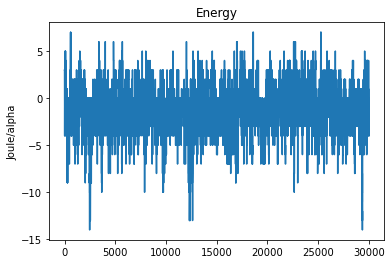

The run timefor the rigid move was: 29.07382822036743 s
The run timefor the monomer move was: 21.336769342422485 s


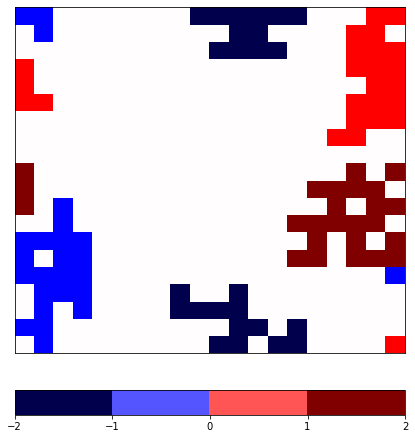

In [19]:
t0_rigid = time.time()
grid_monte_carlo_polymer_rigid, epsilon = run_simulation_with_polymers_fixed_grid(grid_polymers, 30000, 200, show_grid=False, movement="rigid")
print(f"The run timefor the rigid move was: {time.time() - t0_rigid} s")
print(f"The run timefor the monomer move was: {time_monomer} s")
visualize_grid(grid_monte_carlo_polymer_rigid)

The resulting polymer system do not look to different from the one we constructed before running the Monte Carlo algorithm. Despite that, the polymers tend to couple up with other polymers of different charge. As we know, this results in a lower total energy for the system. Moreover, the Monte Carlo runtime increase as we use the rigid movement compared to monomer movement. The main reason that the runtime increases, is that finding a legal move is much more effective for a monomer system, as we only work with one monomer at a time. Alternatively, when moving a polymer, it has to search for legal moves for all monomers making the polymer, each move it makes. Consequently, the number of code-loops, hence the runtime, increase as we implement the rigid move. The runtime for 50 000 Monte Carlo iterations in a monomer system is far less than the time it takes for 30 000 iterations using the rigid move in a polymer system. These results are printed above.

Furthermore, the rigid move is a rather easy function to implement, but it does not give a realistic simulation. In real cells the polymer is not restricted to keep its shape, but can instead clump up or strech out. Therefore we implemented a new type of movement, the medium flexibility move. The medium flexibility move moves much like the rigid move, but during a illegal move the only part of the polymer that is restricted is the row or column that makes the illegal move. This happens as long as the polymer do not break.

We implement this movement in the function called medium_flexible_move. In the function we split the polymer into so called row-polymers or column-polymer, depending on the direction of movement. If the movement is horisontal the polymer is split into row-polymers, and if the movement i vertical the polymer is split into column-polymers. This way the rows or columns that can move, will move, except if the polymer is broken. A polymer is broken if two parts of the polymer is not directly connected. We know that a polymer is broken if there is more than one cluster with the same polymer value in our system. This sequence is implemented to the function check_if_broken_polymer(). After implementation these functions, we can run the Monte-Carlo method so that our results appear more realistic. 

Below is an example of a Monte-Carlo simulation using the medium_flexible_move with 30 000 Monte-Carlo steps. 



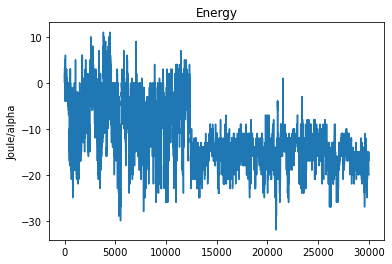

The run time for medium flexible was: 3.7045228481292725 s


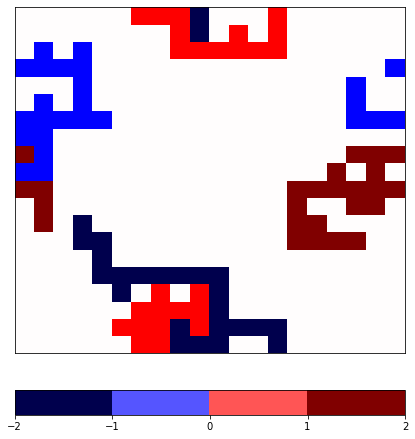

In [20]:
t0_flex = time.time()
grid_monte_carlo_polymer_mediflex, epsilon = run_simulation_with_polymers_fixed_grid(grid_polymers, 30000, 200, movement="medium_flex")
print(f"The run time for medium flexible was: {time.time() - t0_flex} s")
visualize_grid(grid_monte_carlo_polymer_mediflex)


The resulting energy graph using the medium flexible move fluctates around a smaller value than the energy grid we get using the rigid move. After looking at several grids after 30000 Monte Carlo itterations, using the medium flexible move, we noticed that the polymers of opposite charge that stick together long and norrow, compared to the resulting grid from the rigid move. As a result, more monomers of opposite charge are in direct contact, which leads to a lower total energy. To sum up the energy at equilibrium is lower for the medium flexible move, than for the rigid move.

Now that we have a way to model medium flexible movement of polymers, we can finally investigate the formatation of clusters or organelles. To get a sense of how polymer length is related to the formation of clusters we are going to simulate the system at the same temperature, but with different polymer length L. 

Since for the low temperature case above it looked to be at equilibrium within 30 000 steps, a rough upper limit is fine to set at around 50 000 - 100 000 steps. Since we can in reasonalbe time complte 100 samples after equilibrium, we choose n=100 to get a large pool of samples of the amount of clusters.

The values we are interested in are $\langle d \rangle / L$ and $\langle m \rangle$. Here d also refers to the cluster size and m refers to the amount of clusters. We choose 13 evenely spaced values of L between 3 and 39 to get our data. Other values are T=300k, t_r = 1000, N=30 and M=5. This simulation is implemented in the function [run_sim_poly_cluster()](#polymer_cluster), as seen below.

Start
Done: 3.0
Done: 6.0
Done: 9.0
Done: 12.0
Done: 15.0
Done: 18.0
Done: 21.0
Done: 24.0
Done: 27.0
Done: 30.0
Done: 33.0
Done: 36.0
Done: 39.0
Finished


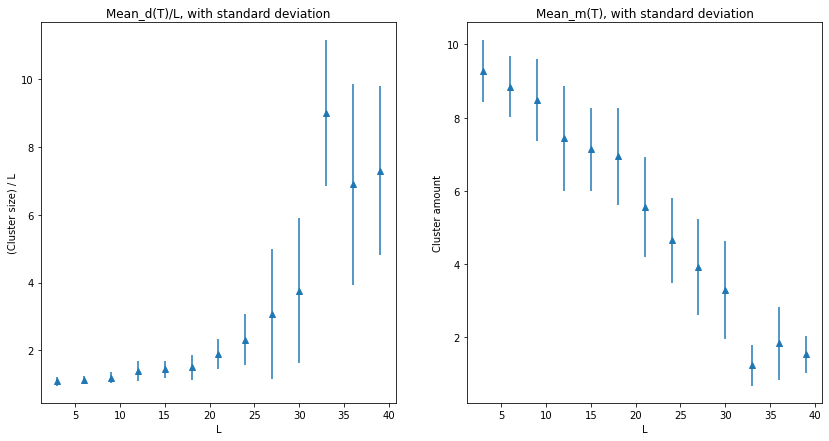

In [21]:
run_sim_poly_cluster()

The plot on the right is to be expected, since with bigger values of L the polymers get larger and will have more neighbor positions where it can lower the total energy. Therfore they will clump more, since the total energy can get drastically lower for polymers with bigger L. Another element to keep in mind is that is simply less vacant spaces left for monomers to occupy, and therfore it is more likely that polymers will be clumped together. 

With lower values of L, the polymers will act more monomer like, since the change between 3 and 1 monomer is clearly less drastic then 1 and 39. With only 5 "monomer" like polymers, it is clearly not likely that alot of them will clump together. By dividing the mean cluster size by L we get a measure of the cluster size if every polymer was a monomer instead. The left plot therefore also supports the idea of bigger clusters being creates when increasing L. This can be compared to making the 5 polymers not act like normal monomers, but rather they will act like larger monomers that are more flexible to reduce the total energy of the system. 

Since the shape of larger polymers are generally more confined, they will generally be more affected by initial conditions. Therefore we expect the results to vary more for larger values of L. Even within the same simulation it looks to vary quite a bit, which can be seen by the large standard deviation of mean cluster size for the larger values of L.

If we were to use rigid move instead, we expect the amount of clusters to be larger. Our thought process being that the polymers will not be able to make long thin shapes to better be able to connect the different polymers into clusters.

Finally lets compare how the much temperature vs L matters in the formation of cluster. To show this we run [run_sim_poly_cluster_compare()](#poly_cluster). This is a modified version of the previous simulation, which goes through 10 values of T and 10 values of L, and plots the results with a 2D surface.

In [14]:
run_sim_poly_cluster_compare()

Start


Our results indicates that is the value L which is the most important factor in the formation of polymers. We think this is the case since L is a more restrictiv property. Larger polymers will have less room to move, and will have more potential ways to decrease their energy. Temperature just introduces some instability.